NY-House-Dataset. **Гучигов Джамбек БИВТ-22-СП-1**

In [ ]:
import pandas as pd
file_path = 'NY-House-Dataset.csv'
df = pd.read_csv(file_path)
df.head()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

y = df['PRICE']  # Целевая переменная

columns_to_keep = ['BEDS', 'BATH', 'PROPERTYSQFT', 'STATE', 'LOCALITY']

#X = df.loc[:, columns_to_keep]

columns_to_remove = [
    'STATE_Astoria, NY 11101', 'STATE_Astoria, NY 11102', 'STATE_Astoria, NY 11103',
    'STATE_Astoria, NY 11105', 'STATE_Astoria, NY 11106', 'STATE_Bayside, NY 11360',
    'STATE_Bayside, NY 11361', 'LOCALITY_Brooklyn', 'LOCALITY_Flatbush',
    'LOCALITY_Kings County', 'LOCALITY_New York', 'LOCALITY_New York County',
    'LOCALITY_Queens', 'LOCALITY_Queens County', 'LOCALITY_Richmond County', 'LONG_NAME',	'FORMATTED_ADDRESS',	'LATITUDE',	'LONGITUDE', 'TYPE',
    'LOCALITY_The Bronx', 'LOCALITY_United States', 'ADDRESS',	'MAIN_ADDRESS',	'ADMINISTRATIVE_AREA_LEVEL_2',	'STREET_NAME', 'BROKERTITLE'
]

df = df.drop(columns=columns_to_remove, errors='ignore')

X =df

#columns_to_drop = ['BROKERTITLE', 'TYPE', 'ADDRESS', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2', 'STREET_NAME','LONG_NAME', 'FORMATTED_ADDRESS', 'LATITUDE','LONGITUDE']
#df = df.drop(columns=columns_to_drop)

#X = pd.get_dummies(X, drop_first=True)

categorical_columns = ['STATE', 'LOCALITY', 'SUBLOCALITY']

X = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Размер обучающей выборки:", X_train.shape, "Целевая переменная:", y_train.shape)
print("Размер тестовой выборки:", X_test.shape, "Целевая переменная:", y_test.shape)

Размер обучающей выборки: (3840, 341) Целевая переменная: (3840,)
Размер тестовой выборки: (961, 341) Целевая переменная: (961,)


In [ ]:
df.isnull().sum()

,0
PRICE,0
BEDS,0
BATH,0
PROPERTYSQFT,0
STATE,0
LOCALITY,0
SUBLOCALITY,0


In [ ]:
X_train

,PRICE,BEDS,BATH,PROPERTYSQFT,"STATE_Astoria, NY 11101","STATE_Astoria, NY 11102","STATE_Astoria, NY 11103","STATE_Astoria, NY 11105","STATE_Astoria, NY 11106","STATE_Bayside, NY 11360",...,SUBLOCALITY_New York,SUBLOCALITY_New York County,SUBLOCALITY_Queens,SUBLOCALITY_Queens County,SUBLOCALITY_Rego Park,SUBLOCALITY_Richmond County,SUBLOCALITY_Riverdale,SUBLOCALITY_Snyder Avenue,SUBLOCALITY_Staten Island,SUBLOCALITY_The Bronx
2851,255000,1,1.0,2184.207862,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3262,160000,1,1.0,2184.207862,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4577,498000,2,2.0,2184.207862,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
1774,555000,3,1.0,1504.000000,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1957,1475000,5,3.0,2637.000000,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,3275000,3,3.0,2184.207862,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
466,1230250,3,2.0,1590.000000,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3092,449000,2,1.0,2184.207862,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3772,775000,3,1.0,1696.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

label_encoder = LabelEncoder()
for column in X_train.select_dtypes(include=['object']).columns:
    X_train_encoded[column] = label_encoder.fit_transform(X_train[column])
    X_test_encoded[column] = label_encoder.transform(X_test[column])

scaler = StandardScaler()
X_train_standart_scaled = scaler.fit_transform(X_train_encoded)
X_test_standart_scaled = scaler.transform(X_test_encoded)
print("X_train_standart_scaled: ")
print(X_train_standart_scaled)
print("")

scaler = MinMaxScaler()
X_train_minmax_scaled = scaler.fit_transform(X_train_encoded)
X_test_minmax_scaled = scaler.transform(X_test_encoded)
print("X_train_minmax_scaled: ")
print(X_train_minmax_scaled)

X_train_standart_scaled: 
[[-0.06306363 -0.90540889 -0.69088001 ... -0.01613953 -0.1148591
  -0.19595697]
 [-0.0657806  -0.90540889 -0.69088001 ... -0.01613953 -0.1148591
   5.10316113]
 [-0.05611391 -0.52068275 -0.19171632 ... -0.01613953 -0.1148591
  -0.19595697]
 ...
 [-0.0575153  -0.52068275 -0.69088001 ... -0.01613953 -0.1148591
  -0.19595697]
 [-0.0481918  -0.13595661 -0.69088001 ... -0.01613953 -0.1148591
  -0.19595697]
 [-0.03349156  0.24876953  0.80661106 ... -0.01613953 -0.1148591
  -0.19595697]]

X_train_minmax_scaled: 
[[1.17582406e-04 0.00000000e+00 2.00000000e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.33445319e-05 0.00000000e+00 2.00000000e-02 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [2.30738230e-04 2.04081633e-02 4.00000000e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.07920800e-04 2.04081633e-02 2.00000000e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.59726556e-04 4.08163265e-02 2.00000000e-02 ... 0.00000000e

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[-0.06306363, -0.90540889, -0.69088001, ..., -0.01613953,
        -0.1148591 , -0.19595697],
       [-0.0657806 , -0.90540889, -0.69088001, ..., -0.01613953,
        -0.1148591 ,  5.10316113],
       [-0.05611391, -0.52068275, -0.19171632, ..., -0.01613953,
        -0.1148591 , -0.19595697],
       ...,
       [-0.0575153 , -0.52068275, -0.69088001, ..., -0.01613953,
        -0.1148591 , -0.19595697],
       [-0.0481918 , -0.13595661, -0.69088001, ..., -0.01613953,
        -0.1148591 , -0.19595697],
       [-0.03349156,  0.24876953,  0.80661106, ..., -0.01613953,
        -0.1148591 , -0.19595697]])

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

print("Категориальные признаки:")
categorical_columns = df.select_dtypes(include=['object']).columns
print(categorical_columns)

label_encoder = LabelEncoder()

for column in categorical_columns:
    df[column + '_LE'] = label_encoder.fit_transform(df[column])

X_train_standard = df.drop(categorical_columns, axis=1).select_dtypes(include=['float64', 'int64'])

X_train_final = pd.concat([X_train_standard.reset_index(drop=True), df.filter(like='_LE').reset_index(drop=True)], axis=1)

print("\nИтоговый DataFrame с нормализованными и закодированными признаками:")
print(X_train_final.head())

Категориальные признаки:
Index(['STATE', 'LOCALITY', 'SUBLOCALITY'], dtype='object')

Итоговый DataFrame с нормализованными и закодированными признаками:
       PRICE  BEDS       BATH  PROPERTYSQFT  STATE_LE  LOCALITY_LE  \
0     315000     2   2.000000        1400.0       207            4   
1  195000000     7  10.000000       17545.0       205            4   
2     260000     4   2.000000        2015.0       301            4   
3      69000     3   1.000000         445.0       161            4   
4   55000000     7   2.373861       14175.0       227            4   

   SUBLOCALITY_LE  STATE_LE  LOCALITY_LE  SUBLOCALITY_LE  
0              10       207            4              10  
1              12       205            4              12  
2              16       301            4              16  
3              12       161            4              12  
4              12       227            4              12  


In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
X_train_one_hot_encoded = one_hot_encoder.fit_transform(X_train)
X_test_one_hot_encoded = one_hot_encoder.transform(X_test)
print("X_train_one_hot_encoded: ")
print(X_train_one_hot_encoded.toarray())
print("")
print("X_test_one_hot_encoded: ")
print(X_test_one_hot_encoded.toarray())
print("")

X_train_one_hot_encoded: 
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]

X_test_one_hot_encoded: 
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]



In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = MyDataset(X_train_one_hot_encoded, X_train_minmax_scaled)
test_dataset = MyDataset(X_test_one_hot_encoded, X_test_minmax_scaled)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

**Обучение простой однослойной нейросети с оптимизатором SGD**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc(x)
        return x


input_size = X_train_one_hot_encoded.shape[1]
output_size = 1
learning_rate = 0.01

model_SimpleNet = SimpleNet(input_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.SGD(model_SimpleNet.parameters(), lr=learning_rate)

num_epochs = 1
count=0
for epoch in range(num_epochs):
    model_SimpleNet.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:

        outputs = model_SimpleNet(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        count+=1
        if count==11:
          print(count)
          break
        print(f"Эпоха {epoch+1}/{num_epochs}, Потери: {running_loss/len(train_dataloader)}")

print("Обучение завершено")

Эпоха 1/1, Потери: 0.0004828734944264094
Эпоха 1/1, Потери: 0.011023054892818133
Эпоха 1/1, Потери: 0.3462421520302693
Эпоха 1/1, Потери: 11.129758590832353
Эпоха 1/1, Потери: 358.3548887991657
Эпоха 1/1, Потери: 11548.543430465832
Эпоха 1/1, Потери: 371929.64343046583
Эпоха 1/1, Потери: 11972718.976763798
Эпоха 1/1, Потери: 385635575.51009715
Эпоха 1/1, Потери: 12429018086.44343
11
Обучение завершено


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 341])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Обучение на тренировочном множестве нейросети посложнее (с 1 скрытым слоем) с оптимизатором Adam

In [ ]:

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x


input_size = X_train_one_hot_encoded.shape[1]
hidden_size = 64
output_size = 1

model_NeuralNetwork = NeuralNetwork(input_size, hidden_size, output_size)

learning_rate = 0.001
optimizer = optim.Adam(model_NeuralNetwork.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

num_epochs = 100
for epoch in range(num_epochs):
    model_NeuralNetwork.train()

    for inputs, targets in train_dataloader:
        optimizer.zero_grad()

        outputs = model_NeuralNetwork(inputs)

        loss = criterion(outputs, targets)

        loss.backward()

        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Эпоха [{epoch+1}/{num_epochs}], Потери: {loss.item():.4f}')

print("Обучение завершено")

Эпоха [10/100], Потери: 0.0084
Эпоха [20/100], Потери: 0.0084
Эпоха [30/100], Потери: 0.0085
Эпоха [40/100], Потери: 0.0085
Эпоха [50/100], Потери: 0.0084
Эпоха [60/100], Потери: 0.0082
Эпоха [70/100], Потери: 0.0084
Эпоха [80/100], Потери: 0.0083
Эпоха [90/100], Потери: 0.0085
Эпоха [100/100], Потери: 0.0085
Обучение завершено


Обучение на тренировочном множестве нейросети еще сложнее (с 3+ скрытыми слоями) с оптимизатором Adam

In [ ]:

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

input_size = X_train_one_hot_encoded.shape[1]
hidden_sizes = [64, 32, 16]
output_size = 1

model_HardNeuralNetwork = NeuralNetwork(input_size, hidden_sizes, output_size)

learning_rate = 0.001
optimizer = optim.Adam(model_HardNeuralNetwork.parameters(), lr=learning_rate)

criterion = nn.MSELoss()

num_epochs = 100
for epoch in range(num_epochs):
    model_HardNeuralNetwork.train()

    for inputs, targets in train_dataloader:

        optimizer.zero_grad()


        outputs = model_HardNeuralNetwork(inputs)

        loss = criterion(outputs, targets)

        loss.backward()

        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Эпоха [{epoch+1}/{num_epochs}], Потери: {loss.item():.4f}')

Эпоха [10/100], Потери: 0.0083
Эпоха [20/100], Потери: 0.0085
Эпоха [30/100], Потери: 0.0083
Эпоха [40/100], Потери: 0.0086
Эпоха [50/100], Потери: 0.0084
Эпоха [60/100], Потери: 0.0085
Эпоха [70/100], Потери: 0.0086
Эпоха [80/100], Потери: 0.0085
Эпоха [90/100], Потери: 0.0086
Эпоха [100/100], Потери: 0.0086


Подсчет loss на train и test множествах, в зависимости от эпохи обучения. Визуализация результата с помощью библиотеки matplotlib (выйдет так называемая learning curve, кривая обучения модели)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 341])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Эпоха [1/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [2/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [3/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [4/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [5/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [6/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [7/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [8/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [9/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [10/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [11/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [12/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [13/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [14/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [15/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [16/100], Обучающий Loss: 0.0085, Тестовый Loss: 0.0084
Эпоха [17/100], О

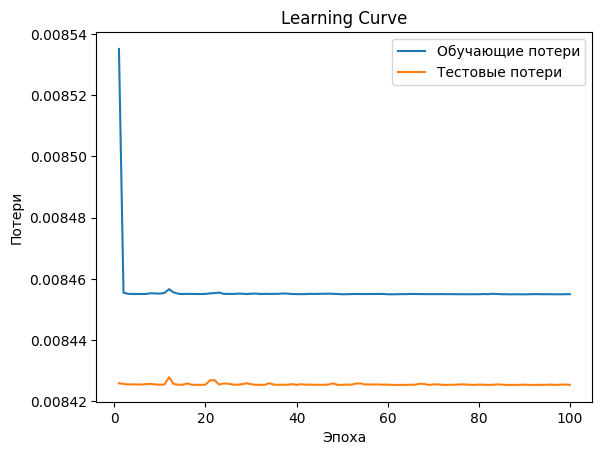

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Определение нейросети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

def train_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()

        train_loss = 0.0
        for inputs, targets in train_dataloader:


            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            train_loss += loss.item() * inputs.size(0)

            loss.backward()
            optimizer.step()

        train_loss = train_loss / len(train_dataloader.dataset)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        for inputs, targets in test_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
        test_loss = test_loss / len(test_dataloader.dataset)
        test_losses.append(test_loss)

        print(f'Эпоха [{epoch+1}/{num_epochs}], Обучающий Loss: {train_loss:.4f}, Тестовый Loss: {test_loss:.4f}')

    plt.plot(range(1, num_epochs+1), train_losses, label='Обучающие потери')
    plt.plot(range(1, num_epochs+1), test_losses, label='Тестовые потери')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

input_size = X_train_one_hot_encoded.shape[1]
hidden_sizes = [64, 32, 16]
output_size = 1

model = NeuralNetwork(input_size, hidden_sizes, output_size)


learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.MSELoss()

num_epochs = 100
train_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs)

Подсчет метрики MAE на train и test множествах

In [ ]:

def calculate_mae(model, data_loader):
    model.eval()
    mae = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            mae += torch.abs(outputs - targets).sum().item()
    mae = mae / len(data_loader.dataset)
    return mae

train_mae_SimpleNet = calculate_mae(model_SimpleNet, train_dataloader)
test_mae_SimpleNet = calculate_mae(model_SimpleNet, test_dataloader)

print(f'MAE на train множестве SimpleNet: {train_mae_SimpleNet:.4f}')
print(f'MAE на test множестве SimpleNet: {test_mae_SimpleNet:.4f}')

train_mae_NeuralNetwork = calculate_mae(model_NeuralNetwork, train_dataloader)
test_mae_NeuralNetwork = calculate_mae(model_NeuralNetwork, test_dataloader)

print(f'MAE на train множестве NeuralNetwork: {train_mae_NeuralNetwork:.4f}')
print(f'MAE на test множестве NeuralNetwork: {test_mae_NeuralNetwork:.4f}')

train_mae_HardNeuralNetwork = calculate_mae(model_HardNeuralNetwork, train_dataloader)
test_mae_HardNeuralNetwork = calculate_mae(model_HardNeuralNetwork, test_dataloader)

print(f'MAE на train множестве HardNeuralNetwork: {train_mae_HardNeuralNetwork:.4f}')
print(f'MAE на test множестве HardNeuralNetwork: {test_mae_HardNeuralNetwork:.4f}')

MAE на train множестве SimpleNet: 9332644505.6000
MAE на test множестве SimpleNet: 9332491794.6472
MAE на train множестве NeuralNetwork: 5.8993
MAE на test множестве NeuralNetwork: 5.8697
MAE на train множестве HardNeuralNetwork: 5.8250
MAE на test множестве HardNeuralNetwork: 5.8105
